In [ ]:
# Install Kaggle package
!pip install kaggle

# Create Kaggle directory and copy API key
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

# Download the dataset from Kaggle
!kaggle datasets download -d prudhvignv/road-damage-classification-and-assessment

# Unzip the dataset
!unzip road-damage-classification-and-assessment.zip

print('Data source import complete.')


Dataset URL: https://www.kaggle.com/datasets/prudhvignv/road-damage-classification-and-assessment
License(s): EU ODP Legal Notice
Archive:  road-damage-classification-and-assessment.zip
  inflating: sih_road_dataset/good/good_001.JPG  
  inflating: sih_road_dataset/good/good_002.JPG  
  inflating: sih_road_dataset/good/good_003.JPG  
  inflating: sih_road_dataset/good/good_004.JPG  
  inflating: sih_road_dataset/good/good_005.JPG  
  inflating: sih_road_dataset/good/good_006.JPG  
  inflating: sih_road_dataset/good/good_007.JPG  
  inflating: sih_road_dataset/good/good_008.JPG  
  inflating: sih_road_dataset/good/good_009.JPG  
  inflating: sih_road_dataset/good/good_010.JPG  
  inflating: sih_road_dataset/good/good_011.JPG  
  inflating: sih_road_dataset/good/good_012.JPG  
  inflating: sih_road_dataset/good/good_013.JPG  
  inflating: sih_road_dataset/good/good_014.JPG  
  inflating: sih_road_dataset/good/good_015.JPG  
  inflating: sih_road_dataset/good/good_016.JPG  
  inflating: s

# 1. Import Library

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torch.utils.data import DataLoader # lets us load data in batches
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline

import time
import os
import copy
import shutil
from sklearn.model_selection import train_test_split

# 2. Load Data

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load dataset
dataset_dir = 'sih_road_dataset'
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

In [ ]:
print("Classes in the dataset:")
for idx, class_name in enumerate(dataset.classes):
    print(f"Class {idx}: {class_name}")

Classes in the dataset:
Class 0: good
Class 1: poor
Class 2: satisfactory
Class 3: very_poor


In [ ]:
# Get all indices
indices = list(range(len(dataset)))

# Split indices into train and remaining
train_indices, remaining_indices = train_test_split(
    indices, test_size=0.21, random_state=42, stratify=dataset.targets
)
val_indices, test_indices = train_test_split(
    remaining_indices, test_size=0.5, random_state=42, stratify=[dataset.targets[i] for i in remaining_indices]
)

In [ ]:
print(len(train_indices))
print(len(val_indices))
print(len(test_indices))

1638
218
218


In [ ]:
# Buat subset untuk train dan test berdasarkan indeks yang telah di-split
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Buat DataLoader untuk train dan test set
train_loader = DataLoader(train_dataset, batch_size=18, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [ ]:
image, label = train_dataset[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([3, 256, 256]) 
Label: 1


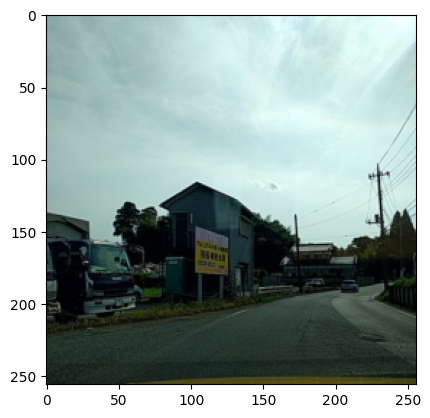

In [ ]:
image = image.permute(1, 2, 0)
plt.imshow(image);

# 3. Convolutional Neural Network

In [ ]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Adjusted based on output size
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 4)  # Number of classes

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = self.pool(X)
        X = F.relu(self.conv2(X))
        X = self.pool(X)
        X = F.relu(self.conv3(X))
        X = self.pool(X)
        X = F.relu(self.conv4(X))
        X = self.pool(X)

        X = X.view(-1, 128 * 16 * 16)  # Flatten the tensor
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)

In [ ]:
for i, (X_train, y_train) in enumerate(train_dataset):
  break

In [ ]:
X_train

tensor([[[0.5255, 0.5255, 0.5373,  ..., 0.9412, 0.9216, 0.9137],
         [0.5255, 0.5294, 0.5373,  ..., 0.9412, 0.9255, 0.9137],
         [0.5412, 0.5373, 0.5294,  ..., 0.9333, 0.9255, 0.9137],
         ...,
         [0.1137, 0.0902, 0.1176,  ..., 0.2549, 0.2431, 0.2471],
         [0.1059, 0.1020, 0.1020,  ..., 0.2549, 0.2471, 0.2510],
         [0.1137, 0.1098, 0.0745,  ..., 0.2784, 0.2706, 0.2667]],

        [[0.6431, 0.6431, 0.6549,  ..., 1.0000, 0.9961, 1.0000],
         [0.6431, 0.6471, 0.6549,  ..., 1.0000, 0.9961, 0.9961],
         [0.6588, 0.6549, 0.6471,  ..., 1.0000, 0.9961, 0.9961],
         ...,
         [0.1647, 0.1333, 0.1569,  ..., 0.2549, 0.2510, 0.2588],
         [0.1569, 0.1451, 0.1412,  ..., 0.2471, 0.2510, 0.2588],
         [0.1647, 0.1529, 0.1137,  ..., 0.2706, 0.2784, 0.2745]],

        [[0.6431, 0.6431, 0.6549,  ..., 0.9961, 0.9922, 0.9922],
         [0.6431, 0.6471, 0.6549,  ..., 1.0000, 0.9961, 0.9922],
         [0.6588, 0.6549, 0.6471,  ..., 1.0000, 0.9961, 1.

In [ ]:
X_train.shape

torch.Size([3, 256, 256])

In [ ]:
torch.manual_seed(42)
model = ConvolutionalNetwork()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [ ]:
for param in model.parameters():
  print(param.numel())  #numel=number of elements/parameters

432
16
4608
32
18432
64
73728
128
16777216
512
65536
128
512
4


In [ ]:
criterion = nn.CrossEntropyLoss() #karena multiclass classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #learning rate

In [ ]:
# Training and Testing
start_time = time.time()
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Move model to the selected device
model = model.to(device)

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Training
    model.train()
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        # Move tensors to the same device as the model
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 91 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{18*b:6}/1638]  loss: {loss.item():10.8f}  accuracy: {trn_corr.item()*100/(18*b):7.3f}%')

    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Testing
    model.eval()
    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(val_loader):
            # Move tensors to the same device as the model
            X_val = X_val.to(device)
            y_val = y_val.to(device)

            y_result = model(X_val)
            predicted = torch.max(y_result.data, 1)[1]
            tst_corr += (predicted == y_val).sum()

    loss = criterion(y_result, y_val)
    test_losses.append(loss.item())
    test_correct.append(tst_corr.item())

    current_time = time.time()
    total = current_time - start_time
print(f'\nDuration: {total/60:.2f} minutes')

epoch:  0  batch:   91 [  1638/1638]  loss: 0.36803702  accuracy:  77.350%
epoch:  1  batch:   91 [  1638/1638]  loss: 0.37400064  accuracy:  90.720%
epoch:  2  batch:   91 [  1638/1638]  loss: 0.52273667  accuracy:  92.186%
epoch:  3  batch:   91 [  1638/1638]  loss: 0.21209696  accuracy:  93.346%
epoch:  4  batch:   91 [  1638/1638]  loss: 0.09791312  accuracy:  94.811%
epoch:  5  batch:   91 [  1638/1638]  loss: 0.05055280  accuracy:  95.543%
epoch:  6  batch:   91 [  1638/1638]  loss: 0.24744545  accuracy:  95.543%
epoch:  7  batch:   91 [  1638/1638]  loss: 0.12281650  accuracy:  97.863%
epoch:  8  batch:   91 [  1638/1638]  loss: 0.01400984  accuracy:  99.145%
epoch:  9  batch:   91 [  1638/1638]  loss: 0.06028026  accuracy:  99.206%

Duration: 5.92 minutes


# 4. Evaluation

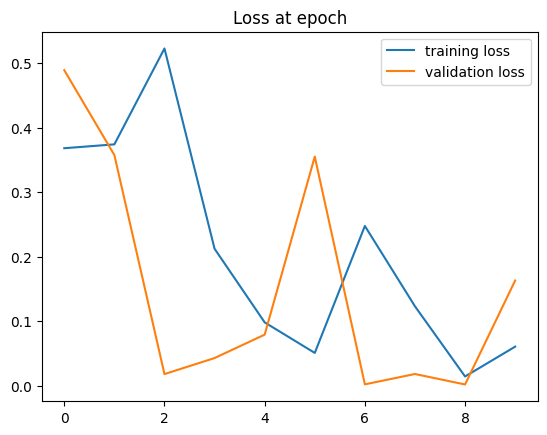

In [ ]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at epoch')
plt.legend();

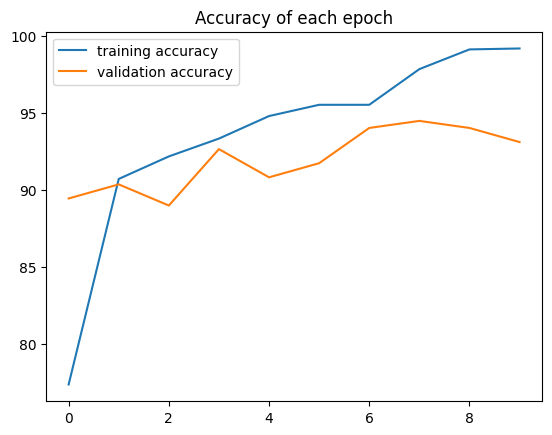

In [ ]:
#accuracy at each epoch
plt.plot([(t*100/1638) for t in train_correct], label='training accuracy')
plt.plot([(t*100/218) for t in test_correct], label='validation accuracy')
plt.title('Accuracy of each epoch')
plt.legend();

In [ ]:
test_load_all = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [ ]:
# Make sure to use the same device as defined previously
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():  # Don't update weights or biases in test data
    correct = 0
    total = 0
    for X_test, y_test in test_load_all:
        # Move test data to the same device as the model
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        y_val = model(X_test)  # Forward pass
        _, predicted = torch.max(y_val, 1)  # Get predicted class indices
        correct += (predicted == y_test).sum().item()  # Count correct predictions
        total += y_test.size(0)  # Count total samples

# Print accuracy
accuracy = (correct / total) * 100
print(f'Test accuracy: {correct}/{total} = {accuracy:.2f}%')

Test accuracy: 192/218 = 88.07%


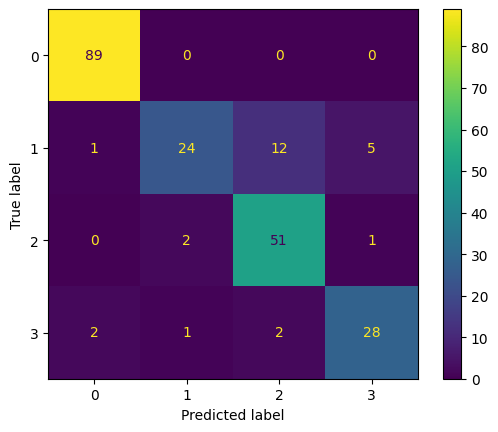


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        89
           1       0.89      0.57      0.70        42
           2       0.78      0.94      0.86        54
           3       0.82      0.85      0.84        33

    accuracy                           0.88       218
   macro avg       0.87      0.84      0.84       218
weighted avg       0.89      0.88      0.87       218



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Make sure to use the same device as defined previously
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_predictions = []
all_labels = []

with torch.no_grad():
    for X_test, y_test in test_load_all:
        # Move tensors to the same device as the model
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        y_val = model(X_test)
        _, predicted = torch.max(y_val, 1)

        # Move predictions and labels back to CPU for numpy conversion
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(4))
disp.plot()
plt.show()

# Print classification report for more detailed metrics
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions))

# 5. Transfer Learning

In [ ]:
from torchvision import models

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
start_time = time.time()
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Training
    model.train()
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        # Move tensors to device
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 91 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{18*b:6}/1638]  loss: {loss.item():10.8f}  accuracy: {trn_corr.item()*100/(18*b):7.3f}%')

    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Testing/Validation
    model.eval()
    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(val_loader):
            # Move tensors to device
            X_val = X_val.to(device)
            y_val = y_val.to(device)

            y_result = model(X_val)
            predicted = torch.max(y_result.data, 1)[1]
            tst_corr += (predicted == y_val).sum()

    loss = criterion(y_result, y_val)
    test_losses.append(loss.item())
    test_correct.append(tst_corr.item())

    current_time = time.time()
    total = current_time - start_time
print(f'\nDuration: {total/60:.2f} minutes')

epoch:  0  batch:   91 [  1638/1638]  loss: 0.56078178  accuracy:  65.507%
epoch:  1  batch:   91 [  1638/1638]  loss: 0.42884010  accuracy:  88.523%
epoch:  2  batch:   91 [  1638/1638]  loss: 0.19986370  accuracy:  93.590%
epoch:  3  batch:   91 [  1638/1638]  loss: 0.38922155  accuracy:  94.505%
epoch:  4  batch:   91 [  1638/1638]  loss: 0.17322367  accuracy:  94.567%
epoch:  5  batch:   91 [  1638/1638]  loss: 0.16237587  accuracy:  95.604%
epoch:  6  batch:   91 [  1638/1638]  loss: 0.07431904  accuracy:  95.604%
epoch:  7  batch:   91 [  1638/1638]  loss: 0.12400969  accuracy:  95.788%
epoch:  8  batch:   91 [  1638/1638]  loss: 0.04576582  accuracy:  96.276%
epoch:  9  batch:   91 [  1638/1638]  loss: 0.15118270  accuracy:  97.253%

Duration: 5.93 minutes


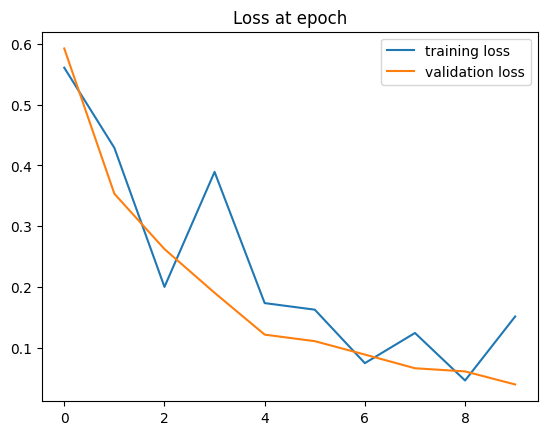

In [ ]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at epoch')
plt.legend();

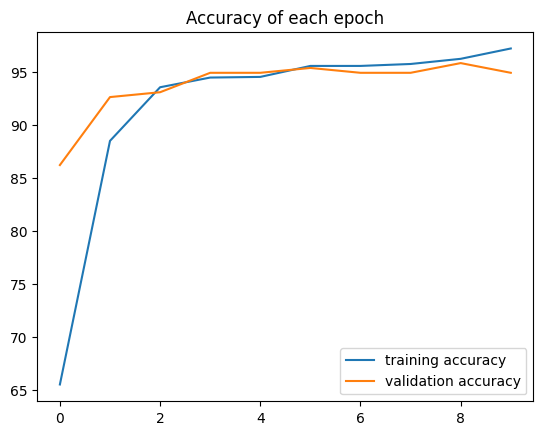

In [ ]:
#accuracy at each epoch
plt.plot([(t*100/1638) for t in train_correct], label='training accuracy')
plt.plot([(t*100/218) for t in test_correct], label='validation accuracy')
plt.title('Accuracy of each epoch')
plt.legend();

In [ ]:
test_load_all = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [ ]:
# Ensure we have the device defined
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

with torch.no_grad():  # Don't update weights or biases in test data
    correct = 0
    total = 0
    for X_test, y_test in test_load_all:
        # Move test data to the same device as the model
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        y_val = model(X_test)  # Forward pass
        _, predicted = torch.max(y_val, 1)  # Get predicted class indices
        correct += (predicted == y_test).sum().item()  # Count correct predictions
        total += y_test.size(0)  # Count total samples

# Print accuracy
accuracy = (correct / total) * 100
print(f'Test accuracy: {correct}/{total} = {accuracy:.2f}%')

Using device: cuda
Test accuracy: 206/218 = 94.50%


Using device: cuda


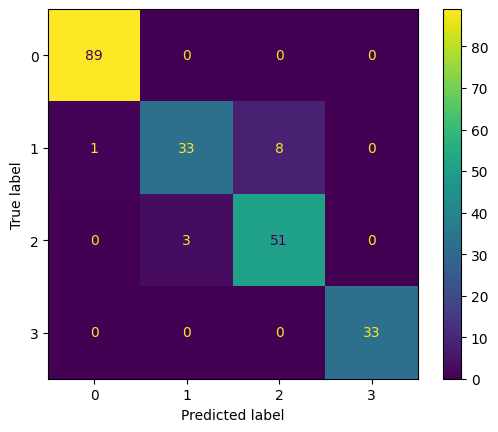


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        89
           1       0.92      0.79      0.85        42
           2       0.86      0.94      0.90        54
           3       1.00      1.00      1.00        33

    accuracy                           0.94       218
   macro avg       0.94      0.93      0.94       218
weighted avg       0.95      0.94      0.94       218



In [ ]:
# Make sure the device is defined
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

all_predictions = []
all_labels = []

with torch.no_grad():
    for X_test, y_test in test_load_all:
        # Move test data to the same device as the model
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        y_val = model(X_test)
        _, predicted = torch.max(y_val, 1)

        # Move predictions and labels back to CPU for numpy conversion
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(y_test.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(4))
disp.plot()
plt.show()

# Optional: Add a classification report for more detailed metrics
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions))

In [ ]:
# Save the entire model (architecture + weights)
torch.save(model, 'road_damage_resnet18_full.pth')

In [ ]:
# For PyTorch 2.6+ in Colab
import torch
from torch import nn
import torchvision.models as models

# Method 1: Load with weights_only=False (less secure but works)
try:
    print("Trying to load model with weights_only=False...")
    full_model = torch.load('road_damage_resnet18_full.pth', weights_only=False)

    # Save just the state dictionary
    torch.save(full_model.state_dict(), 'road_damage_resnet18_state_dict.pth')
    print("Successfully saved model state dictionary!")

except Exception as e:
    print(f"Error with method 1: {e}")

    # Method 2: Add the ResNet class to safe globals
    print("\nTrying method 2 with safe globals...")
    try:
        from torchvision.models.resnet import ResNet
        torch.serialization.add_safe_globals([ResNet])

        full_model = torch.load('road_damage_resnet18_full.pth')
        torch.save(full_model.state_dict(), 'road_damage_resnet18_state_dict.pth')
        print("Successfully saved model state dictionary!")

    except Exception as e:
        print(f"Error with method 2: {e}")

        # Method 3: Create a new model and try to load state dict directly
        print("\nTrying method 3 with new model...")
        try:
            # Create a fresh ResNet18 model
            new_model = models.resnet18(pretrained=False)
            num_ftrs = new_model.fc.in_features
            new_model.fc = nn.Linear(num_ftrs, 4)  # 4 classes

            # Try to load the parameters using a context manager
            with torch.serialization.safe_globals([ResNet]):
                checkpoint = torch.load('road_damage_resnet18_full.pth')

            # If it's the full model, get its state dict
            if isinstance(checkpoint, nn.Module):
                state_dict = checkpoint.state_dict()
            elif isinstance(checkpoint, dict):
                state_dict = checkpoint.get('state_dict', checkpoint)

            # Save just the state dictionary
            torch.save(state_dict, 'road_damage_resnet18_state_dict.pth')
            print("Successfully saved model state dictionary!")

        except Exception as e:
            print(f"Error with method 3: {e}")

            # Method 4: Last resort - train a new model
            print("\nAll methods failed. If you still have the training code, consider retraining the model and saving just the state_dict.")
            print("Alternatively, try downgrading PyTorch to a version below 2.6")

Trying to load model with weights_only=False...
Successfully saved model state dictionary!
